Import of Necessary Library

In [1]:
import numpy as np 
import pandas as pd 
import os
import tensorflow as tf
tf.keras.backend.clear_session()
import xml.etree.ElementTree as ET
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from pathlib import Path
import random
import glob

Seed Intialization

In [2]:
import numpy as np
import random
import tensorflow as tf
import os

def set_seed(seed_value=42):
    """Set seed for reproducibility.""" 
     
    random.seed(seed_value)
    np.random.seed(seed_value)
    tf.random.set_seed(seed_value)

set_seed(42)



Loading the dataset from kaggle/input folder

In [3]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/model-architect/file.py
/kaggle/input/deepglobe-road-extraction-dataset/class_dict.csv
/kaggle/input/deepglobe-road-extraction-dataset/metadata.csv
/kaggle/input/deepglobe-road-extraction-dataset/valid/704062_sat.jpg
/kaggle/input/deepglobe-road-extraction-dataset/valid/235424_sat.jpg
/kaggle/input/deepglobe-road-extraction-dataset/valid/59598_sat.jpg
/kaggle/input/deepglobe-road-extraction-dataset/valid/156684_sat.jpg
/kaggle/input/deepglobe-road-extraction-dataset/valid/993402_sat.jpg
/kaggle/input/deepglobe-road-extraction-dataset/valid/373475_sat.jpg
/kaggle/input/deepglobe-road-extraction-dataset/valid/791459_sat.jpg
/kaggle/input/deepglobe-road-extraction-dataset/valid/407466_sat.jpg
/kaggle/input/deepglobe-road-extraction-dataset/valid/504054_sat.jpg
/kaggle/input/deepglobe-road-extraction-dataset/valid/832447_sat.jpg
/kaggle/input/deepglobe-road-extraction-dataset/valid/868508_sat.jpg
/kaggle/input/deepglobe-road-extraction-dataset/valid/685013_sat.jpg
/kaggle/inp

In [4]:
class_dict = pd.read_csv("/kaggle/input/deepglobe-road-extraction-dataset/class_dict.csv")  
metadata = pd.read_csv("/kaggle/input/deepglobe-road-extraction-dataset/metadata.csv") 


In [5]:
print(class_dict.head())
print("------------------------")
print(metadata.head())


         name    r    g    b
0        road  255  255  255
1  background    0    0    0
------------------------
   image_id  split        sat_image_path              mask_path
0    100034  train  train/100034_sat.jpg  train/100034_mask.png
1    100081  train  train/100081_sat.jpg  train/100081_mask.png
2    100129  train  train/100129_sat.jpg  train/100129_mask.png
3    100703  train  train/100703_sat.jpg  train/100703_mask.png
4    100712  train  train/100712_sat.jpg  train/100712_mask.png


Image Preprocessing

image_size = (256, 256)
batch_size = 16
augment_probability = 0.3

In [4]:
import os
import cv2
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def load_image_mask_pairs(image_folder):
    """Pairs image and mask files based on common prefixes."""
    image_files = sorted([f for f in os.listdir(image_folder) if '_sat' in f])
    mask_files = sorted([f for f in os.listdir(image_folder) if '_mask' in f])

    paired_files = []
    for image_file in image_files:
        base_name = image_file.replace('_sat.jpg', '').replace('_sat.jpeg', '').replace('_sat.png', '')
        corresponding_mask = next((m for m in mask_files if base_name in m), None)
        if corresponding_mask:
            paired_files.append((os.path.join(image_folder, image_file), os.path.join(image_folder, corresponding_mask)))

    if not paired_files:
        raise ValueError("No paired images and masks found. Check the file naming convention.")
    
    return paired_files


def preprocess_image(image_path, image_size=(256, 256), is_mask=False):
    """Preprocess an image or mask."""
    if is_mask:
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        if image is None:
            raise FileNotFoundError(f"Unable to read mask file {image_path}")
        image = cv2.resize(image, image_size, interpolation=cv2.INTER_NEAREST)
        image = (image > 0).astype(np.float32)  
        image = np.expand_dims(image, axis=-1)  
    else:
        image = cv2.imread(image_path)
        if image is None:
            raise FileNotFoundError(f"Unable to read image file {image_path}")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, image_size, interpolation=cv2.INTER_LINEAR)
        image = image.astype(np.float32) / 255.0  # Normalizing to [0, 1]
    
    return image


def apply_augmentation(image, mask, augment_probability=0.3):
    """Applies identical augmentation to an image and its corresponding mask."""
    if np.random.rand() < augment_probability:
        image_datagen = ImageDataGenerator(
            rotation_range=30, 
            width_shift_range=0.1, 
            height_shift_range=0.1, 
            shear_range=0.1, 
            zoom_range=0.1, 
            horizontal_flip=True, 
            fill_mode='nearest'
        )
        seed = np.random.randint(1e6) 
        image = image_datagen.random_transform(image, seed=seed)
        mask = image_datagen.random_transform(mask, seed=seed)
    return image, mask


def load_images_and_masks(image_folder, image_size=(256, 256), batch_size=16, augment_probability=0.3):
    """Load, preprocess, and augment images and masks."""
    paired_files = load_image_mask_pairs(image_folder)
    np.random.shuffle(paired_files) 
    total_samples = len(paired_files)
    images = []
    masks = []

    for i in range(0, total_samples, batch_size):
        batch_files = paired_files[i:i+batch_size]

        for image_path, mask_path in batch_files:
            image = preprocess_image(image_path, image_size=image_size, is_mask=False)
            mask = preprocess_image(mask_path, image_size=image_size, is_mask=True)
            image, mask = apply_augmentation(image, mask, augment_probability)

            images.append(image)
            masks.append(mask)

    images = np.array(images)
    masks = np.array(masks)

    if images.shape[0] != masks.shape[0]:
        print(f"Warning: Number of images ({images.shape[0]}) does not match number of masks ({masks.shape[0]}).")
    
    return images, masks



image_folder = '/kaggle/input/deepglobe-road-extraction-dataset/train'
image_size = (256, 256)
batch_size = 16
augment_probability = 0.3


images, masks = load_images_and_masks(image_folder, image_size=image_size, batch_size=batch_size, augment_probability=augment_probability)

print(f"Processed Images Shape: {images.shape}")
print(f"Processed Masks Shape: {masks.shape}")    


Processed Images Shape: (6226, 256, 256, 3)
Processed Masks Shape: (6226, 256, 256, 1)


Function to display train image and mask side by side

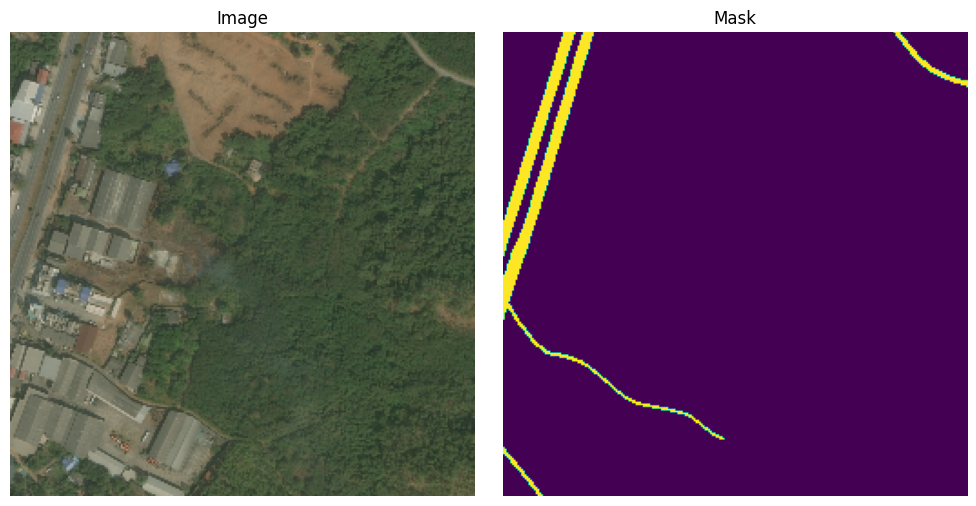

In [6]:

def display_image_mask(images, masks, index):
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    
    axes[0].imshow(images[index])
    axes[0].set_title('Image')
    axes[0].axis('off')
    
    axes[1].imshow(masks[index])
    axes[1].set_title('Mask')
    axes[1].axis('off')
    
    plt.tight_layout()
    plt.show()


index = np.random.randint(len(images)) 


display_image_mask(images, masks, index)

Splitting the images and mask as train and validation in ratio of 0.2 with random state 42

In [7]:
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import Model, Sequential

X_train, X_valid, y_train, y_valid = train_test_split(images,
                                                      masks,
                                                      test_size=0.2,
                                                      random_state=42)

Importing the model architecture from file.py 

In [8]:
import sys
sys.path.append('/kaggle/input/model-architect')
from file import unet_generator

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [9]:
model = unet_generator()

In [10]:
model.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7             │ (None, 256, 256, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ functional (Functional)   │ [(None, 128, 128,      │     12,944,960 │ input_layer_7[0][0]    │
│                           │ 128), (None, 128, 128, │                │                        │
│                           │ 128), (None, 64, 64,   │                │                        │
│                           │ 256), (None, 64, 64,   │                │                        │
│                           │ 256), (None, 32, 32,   │                │                        │
│                           │ 512), (None, 32, 32,   │                │                        │
│                           │ 512), (None, 16, 16,   │                │                        │
│                           │ 512)]                  │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential (Sequential)   │ (None, 16, 16, 512)    │      2,361,344 │ functional[1][6]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_1 (Sequential) │ (None, 32, 32, 512)    │      2,361,344 │ sequential[1][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_1             │ (None, 128, 128, 256)  │              0 │ sequential_1[1][0],    │
│ (Concatenate)             │                        │                │ functional[1][4],      │
│                           │                        │                │ sequential_3[1][0],    │
│                           │                        │                │ functional[1][2],      │
│                           │                        │                │ sequential_5[1][0],    │
│                           │                        │                │ functional[1][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_3 (Dropout)       │ (None, 32, 32, 1024)   │              0 │ concatenate_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_2 (Sequential) │ (None, 32, 32, 256)    │      2,360,320 │ dropout_3[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_3 (Sequential) │ (None, 64, 64, 256)    │        590,848 │ sequential_2[1][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_4 (Dropout)       │ (None, 64, 64, 512)    │              0 │ concatenate_1[1][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_4 (Sequential) │ (None, 64, 64, 128)    │        590,336 │ dropout_4[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_5 (Sequential) │ (None, 128, 128, 128)  │        147,968 │ sequential_4[1][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_5 (Dropout)       │ (None, 128, 128, 256)  │              0 │ concatenate_1[2][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose_1        │ (None, 256, 256, 1)    │          2,305 │ dropout_5[0][0]        │
│ (Conv2DTranspose)    

 Total params: 21,359,425 (81.48 MB)

 Trainable params: 8,410,881 (32.08 MB)

 Non-trainable params: 12,948,544 (49.39 MB)

Intilaizaing earlystopping and model checkpoint 

In [11]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    patience=4,               
    mode='max',               
    restore_best_weights=True 
)
model_checkpoint_cb = tf.keras.callbacks.ModelCheckpoint('checkpoint.weights.h5',
                                                         save_best_only=True,
                                                         save_weights_only=True
                                                        )

Evaluation metrices

Intersection over Union:It is defined as the ratio of the area of overlap between the predicted and ground truth masks to the area of their union. The value of IoU lies between 0 and 1:

1 means perfect overlap between predicted and ground truth,
0 means no overlap.

Dice Coefficient:The Dice coefficient used to measure the similarity between the predicted and ground truth masks.Measures the harmonic mean of precision and recall. 
The Dice coefficient also lies between 0 and 1:
1 means perfect overlap,
0 means no overlap.



In [12]:
from tensorflow.keras import backend as K

def iou_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(K.abs(y_true * y_pred), axis=[1, 2])
    union = K.sum(y_true, axis=[1, 2]) + K.sum(y_pred, axis=[1, 2]) - intersection
    iou = K.mean((intersection + smooth) / (union + smooth))
    return iou

def dice_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(y_true * y_pred, axis=[1, 2])
    union = K.sum(y_true, axis=[1, 2]) + K.sum(y_pred, axis=[1, 2])
    dice = K.mean((2. * intersection + smooth) / (union + smooth))
    return dice


Function to save input,true mask and predicted mask during training of model

In [13]:

import os

IMG_SIZE = [256, 256]

def visualize(display_list, epoch=None):
    """Visualizes and saves the input, true mask, and predicted mask."""
    plt.figure(figsize=(15, 15))
    title = ['Input Image', 'True Mask', 'Predicted Mask']
    
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    

    if epoch is not None:
        save_path = f'epoch_{epoch}_prediction.png'
    else:
        save_path = 'prediction.png'
    
    plt.savefig(save_path)  
    plt.close()  
    print(f"Image saved as {save_path}")

def show_predictions(sample_image, sample_mask, epoch=None):
    """Show and save predictions of a sample image."""
    pred_mask = model.predict(sample_image[tf.newaxis, ...])
    pred_mask = pred_mask.reshape(IMG_SIZE[0], IMG_SIZE[1], 1)
    visualize([sample_image, sample_mask, pred_mask], epoch)

Initalize the epochs, here it is 30

In [14]:
epochs = 30

Used AdamW as optimizer and binaryCrossEntropy for the loss function with IoU and Dice Coefficient as evalutaion metrics

In [ ]:
class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs=None):
        if epoch  % 2 == 0: 
            print(f"Epoch {epoch}: Saving predictions")
            show_predictions(X_valid[0], y_valid[0], epoch) 

from tensorflow.keras.optimizers import Adamax,AdamW

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.001, 
    decay_steps=1000, 
    decay_rate=0.96, 
    staircase=True
)

optimizer = AdamW(learning_rate=lr_schedule, weight_decay=1e-4, clipnorm=1.0)



model.compile(optimizer=optimizer,
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[iou_coef, dice_coef])


model_history = model.fit(X_train, y_train, epochs=epochs,
                        validation_data=(X_valid, y_valid),
                          callbacks=[DisplayCallback(),model_checkpoint_cb])

Epoch 0: Saving predictions
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
Image saved as epoch_0_prediction.png
Epoch 1/30
156/156 ━━━━━━━━━━━━━━━━━━━━ 195s 970ms/step - dice_coef: 0.1384 - iou_coef: 0.0769 - loss: 0.1871 - val_dice_coef: 0.2555 - val_iou_coef: 0.1522 - val_loss: 0.1407
Epoch 2/30
156/156 ━━━━━━━━━━━━━━━━━━━━ 88s 564ms/step - dice_coef: 0.2208 - iou_coef: 0.1278 - loss: 0.1204 - val_dice_coef: 0.2819 - val_iou_coef: 0.1706 - val_loss: 0.1106
Epoch 2: Saving predictions
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Image saved as epoch_2_prediction.png
Epoch 3/30
156/156 ━━━━━━━━━━━━━━━━━━━━ 88s 565ms/step - dice_coef: 0.2367 - iou_coef: 0.1384 - loss: 0.1161 - val_dice_coef: 0.2826 - val_iou_coef: 0.1711 - val_loss: 0.1057
Epoch 4/30
156/156 ━━━━━━━━━━━━━━━━━━━━ 88s 565ms/step - dice_coef: 0.2477 - iou_coef: 0.1459 - loss: 0.1135 - val_dice_coef: 0.2744 - val_iou_coef: 0.1654 - val_loss: 0.1046
Epoch 4: Saving predictions
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Image saved as epoch_4_pred

In [17]:
model_history.history.keys()

dict_keys(['dice_coef', 'iou_coef', 'loss', 'val_dice_coef', 'val_iou_coef', 'val_loss'])

Visualization of metrices : ['dice_coef', 'iou_coef', 'loss', 'val_dice_coef', 'val_iou_coef', 'val_loss']

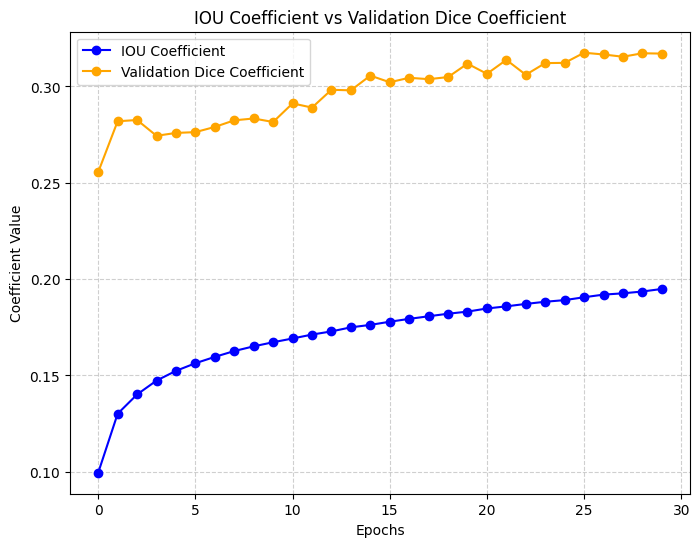

In [28]:


plt.figure(figsize=(8, 6))  
plt.plot(model_history.history['iou_coef'], label='IOU Coefficient', color='blue', linestyle='-', marker='o')
plt.plot(model_history.history['val_dice_coef'], label='Validation Dice Coefficient', color='orange', linestyle='-', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Coefficient Value')
plt.title('IOU Coefficient vs Validation Dice Coefficient')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6) 
plt.show()


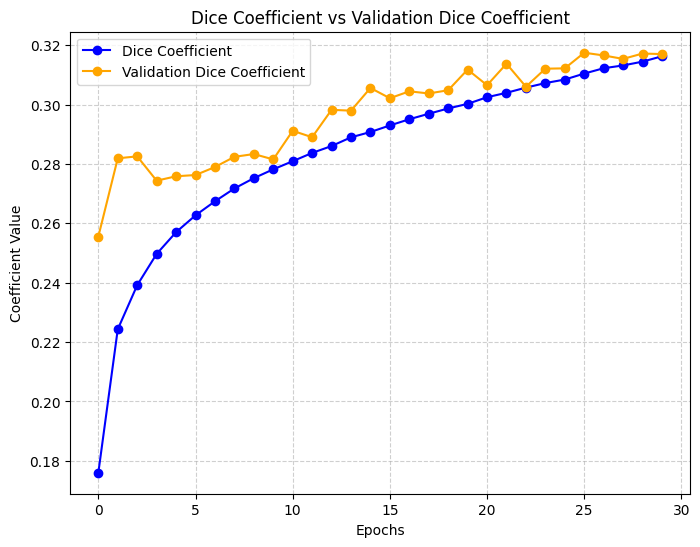

In [30]:

plt.figure(figsize=(8, 6)) 
plt.plot(model_history.history['dice_coef'], label='Dice Coefficient', color='blue', linestyle='-', marker='o')
plt.plot(model_history.history['val_dice_coef'], label='Validation Dice Coefficient', color='orange', linestyle='-', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Coefficient Value')
plt.title('Dice Coefficient vs Validation Dice Coefficient')
plt.legend(loc='best') 
plt.grid(True, linestyle='--', alpha=0.6) 
plt.show()

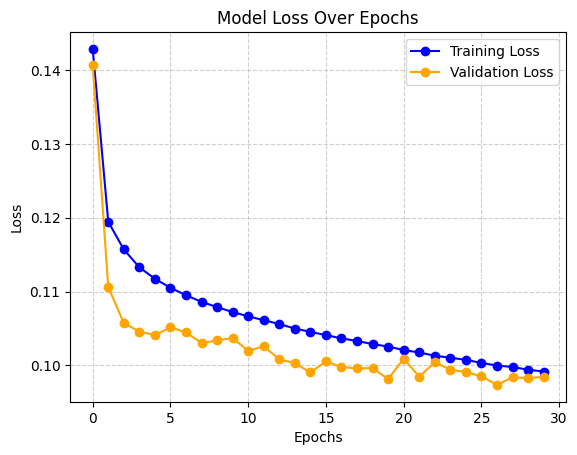

In [31]:
plt.figure()
plt.plot(model_history.history['loss'], label='Training Loss', color='blue', linestyle='-', marker='o')
plt.plot(model_history.history['val_loss'], label='Validation Loss', color='orange', linestyle='-', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss Over Epochs')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

Model weights is saved 

In [25]:
model.save_weights('v1.weights.h5')

To visualize the image,its original mask and predicted mask with final model

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


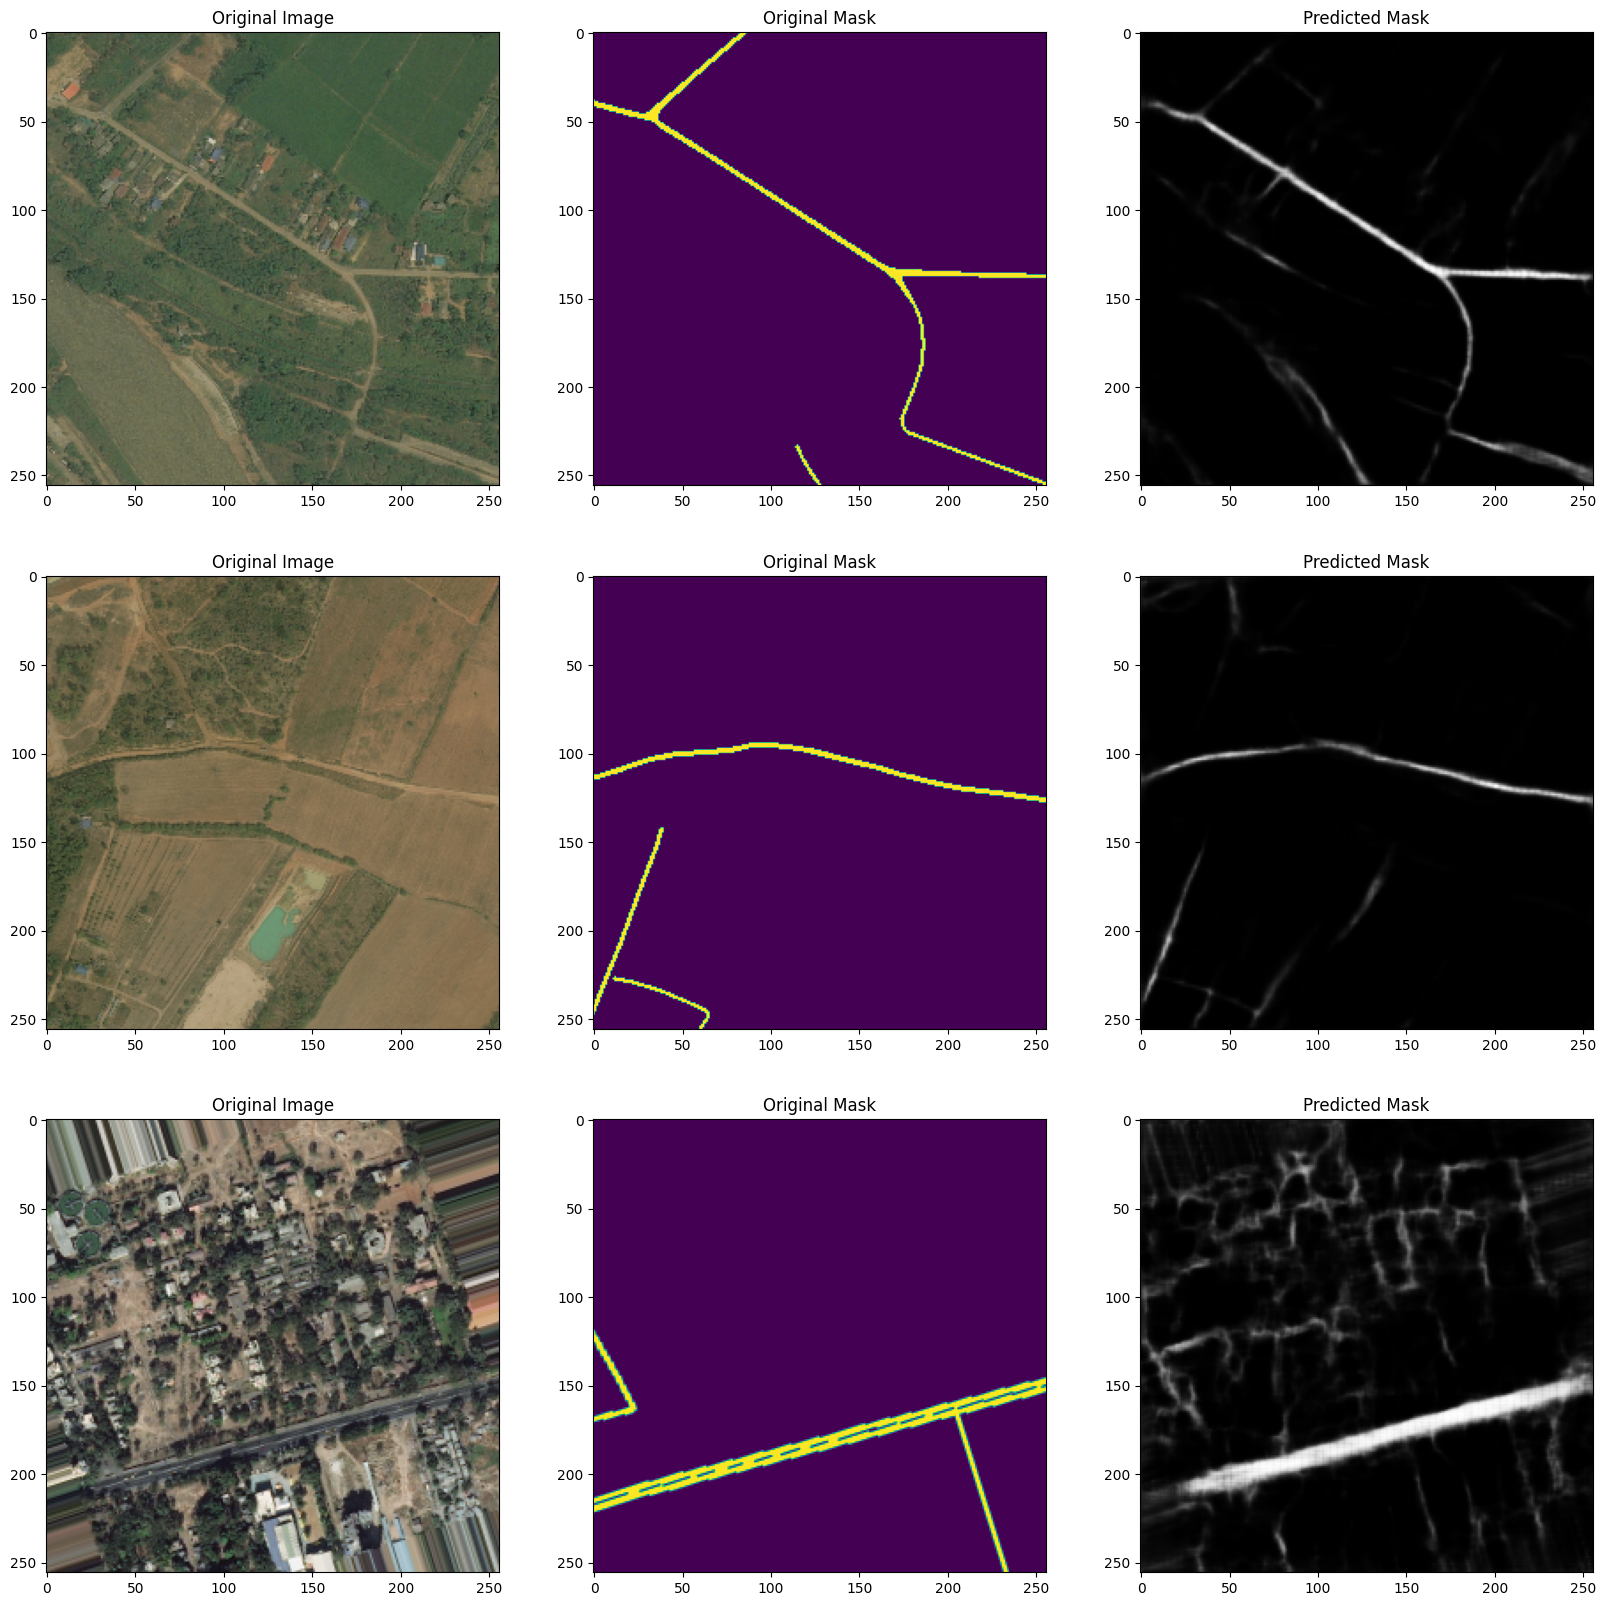

In [27]:
figure, axes = plt.subplots(3,3, figsize=(20,20))

for i in range(0,3):
    rand_num = random.randint(0,5)
    original_img = X_valid[rand_num]
    axes[i,0].imshow(original_img)
    axes[i,0].title.set_text('Original Image')

    original_mask = y_valid[rand_num]
    axes[i,1].imshow(original_mask)
    axes[i,1].title.set_text('Original Mask')

    original_img = np.expand_dims(original_img, axis=0)
    predicted_mask = model.predict(original_img).reshape(256,256)
    axes[i,2].imshow(predicted_mask, cmap='gray')
    axes[i,2].title.set_text('Predicted Mask')

Function to visualize predicted mask of test_dataset

In [33]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def load_and_preprocess_image(image_path, target_size=(256, 256)):

    img = cv2.imread(image_path) 
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  
    img_resized = cv2.resize(img_rgb, target_size) 
    img_normalized = img_resized.astype('float32') / 255.0 
    return img_normalized



def predict_mask(model, image):
    """
    Predict the mask for the input image using the provided model.
    
    Args:
        model: Trained model for prediction.
        image (np.ndarray): Preprocessed image.
    
    Returns:
        np.ndarray: Predicted mask.
    """
    image_input = np.expand_dims(image, axis=0)  
    predicted_mask = model.predict(image_input)  
    return np.squeeze(predicted_mask) 


def display_results(original_image, predicted_mask):
    """
    Display the original image and its predicted mask.
    
    Args:
        original_image (np.ndarray): The original image.
        predicted_mask (np.ndarray): The predicted mask.
    """
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    
    axes[0].imshow(original_image)
    axes[0].set_title('Original Image')
    axes[0].axis('off')  
    
    axes[1].imshow(predicted_mask, cmap='gray')
    axes[1].set_title('Predicted Mask')
    axes[1].axis('off') 
    
    plt.tight_layout()
    plt.show()






1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


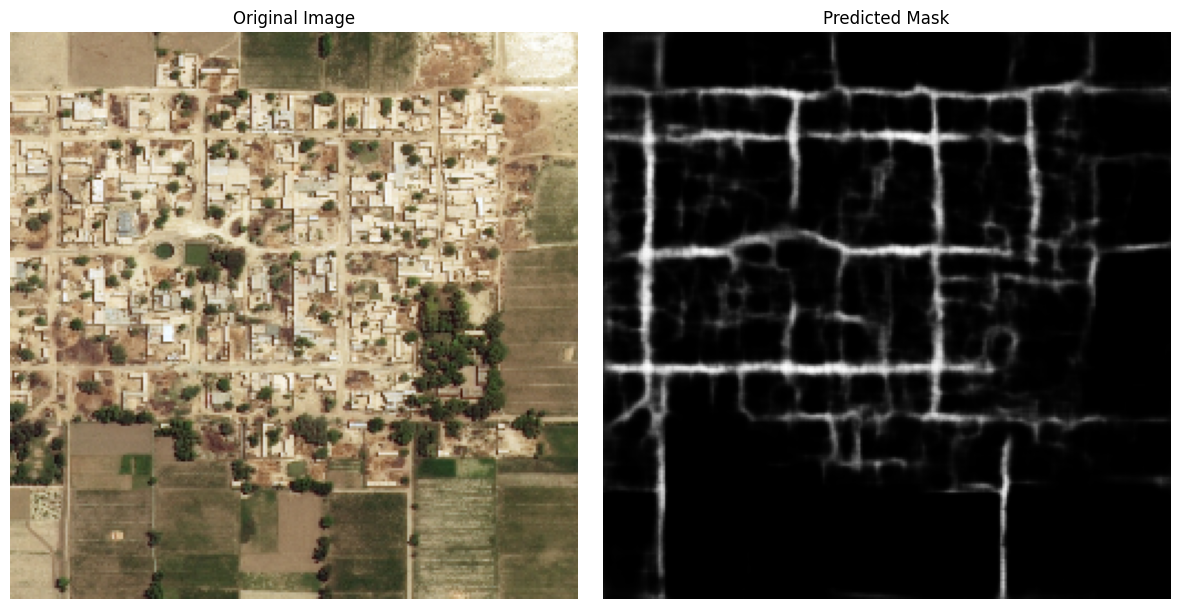

In [37]:
image_path = '/kaggle/input/deepglobe-road-extraction-dataset/test/100393_sat.jpg' 
img_resized = load_and_preprocess_image(image_path)
predicted_mask = predict_mask(model, img_resized)
display_results(img_resized, predicted_mask)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


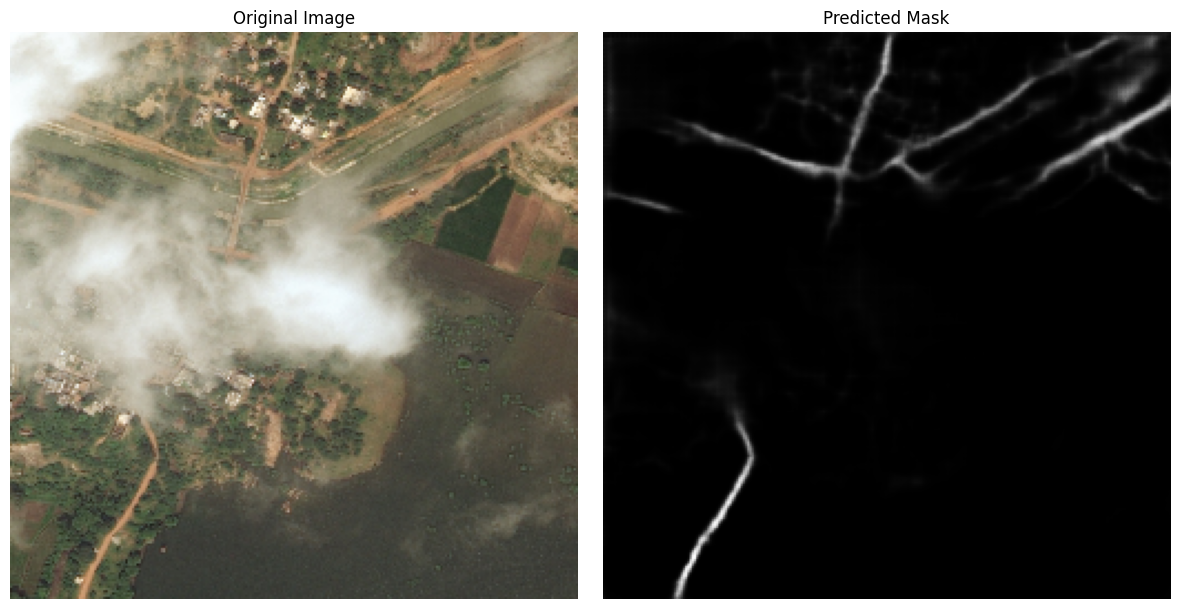

In [38]:

image_path = '/kaggle/input/deepglobe-road-extraction-dataset/test/111322_sat.jpg' 
img_resized = load_and_preprocess_image(image_path)
predicted_mask = predict_mask(model, img_resized)
display_results(img_resized, predicted_mask)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


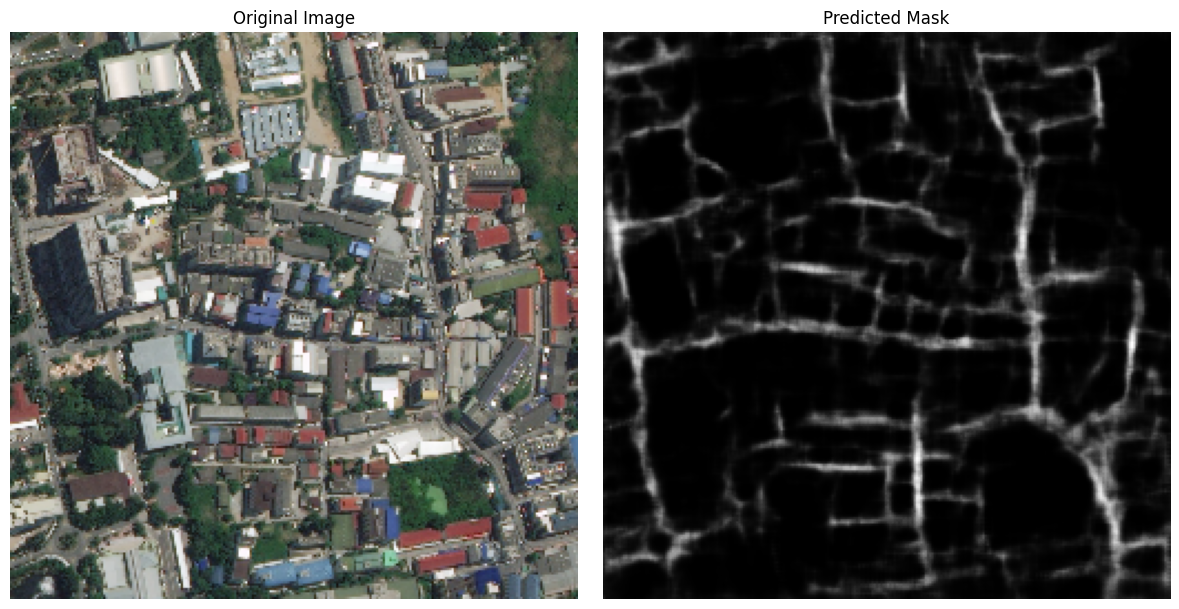

In [39]:
image_path = '/kaggle/input/deepglobe-road-extraction-dataset/test/123077_sat.jpg' 
img_resized = load_and_preprocess_image(image_path)
predicted_mask = predict_mask(model, img_resized)
display_results(img_resized, predicted_mask)